In [1]:
import tensorflow
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Initial data preparation

In [4]:
def add_derived_columns(df):                               # step 1: add JID and standartize timestamps 
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def sample_campaigns(df, n_campaigns):                     # step 2.1: reduce the dataset by sampling campaigns
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def filter_journeys_by_length(df, min_touchpoints):        # step 2.2: remove short (trivial) journeys
    grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
    return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def balance_conversions(df):                               # step 3: balance the dataset: 
    df_minority = df[df.conversion == 1]                   # The number of converted and non-converted events should be equal.
    df_majority = df[df.conversion == 0]                   # We take all converted journeys and iteratively add non-converted 
                                                           # samples until the datset is balanced. We do it this way becasue  
    df_majority_jids = np.array_split(                     # we are trying to balance the number of events, but can add only
          df_majority['jid'].unique(),                     # the whole journeys.
          100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([
            df_majority_sampled, 
            df_majority[df_majority.jid.isin(jid_chunk)]
        ])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):      # step 4: one-hot encoding for categorical variables
    mapper = {}                                             # We use custom mapping becasue IDs in the orginal dataset
    for i, col_name in enumerate(column_names):             # are not sequential, and standard one-not encoding 
        for val in df[col_name].unique():                   # provided by Keras does not handle this properly.
            mapper[val*10 + i] = len(mapper)
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            mapped_val_id = mapper[val*10 + i]
            v[mapped_val_id] = 1
        return v    
    
    df_ext = df.copy()
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
n_campaigns = 400

data_file = 'data/criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')
df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
# all categories are mapped to one vector  
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
# the final dataframe used for modeling
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [5]:
df6.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
140635,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,11409686,1973606,22644417,9312274,21091111,24607497_-1,7.487274e-07,0.163526,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
399229,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,5824237,1973606,9180723,29841067,29196072,7306395_3063962,1.123091e-06,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
536296,4,19923387,31772643,0,-1,-1,0,0,-1,-1,...,32440044,32440041,14074087,29196072,21091108,19923387_-1,1.497455e-06,0.069316,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
399460,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,32440044,1973606,2687461,29841067,21091108,93907_-1,1.497455e-06,0.101299,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
130405,7,5588915,27491436,0,-1,-1,0,0,-1,-1,...,28928366,29196072,21857352,29196072,29196072,5588915_-1,2.620546e-06,0.000000,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Data exploration

In [ ]:
def journey_lenght_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_lenght_histogram(df4)

plt.plot(range(len(hist_all)), hist_all, label='all journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

## Last Touch Attribution

In [18]:
def last_touch_attribution(df):
    
    # count the number of events for each campaign in df
    def count_by_campaign(df):                         
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    # count the number of impressions for each campaign
    campaign_impressions = count_by_campaign(df)       
    
    # count the number of times the campaign is the last touch before the conversion
    dfc = df[df['conversion'] == 1]
    idx = dfc.groupby(['jid'])['timestamp_norm'].transform(max) == dfc['timestamp_norm']
    campaign_conversions = count_by_campaign(dfc[idx])
        
    return campaign_conversions / campaign_impressions

lta = last_touch_attribution(df6)

       timestamp       uid  campaign conversion conversion_timestamp  \
399229         3   7306395  29427842          1              1449193   
546638        25   6013772  15184511          1               138469   
611441        30   9451380  17321082          1               355909   
432212       101   3208958  28739284          1              2469937   
588037       156   8361406   2946551          1                  815   
...          ...       ...       ...        ...                  ...   
273775   2671171  21464622  14121532          1              4738990   
145828   2671175   4642451   9106406          1              2671200   
600673   2671176  19065515   8980584          1              4656976   
527838   2671178  14549073  16823030          1              3559886   
471736   2671178  11373089   2946551          1              4574535   

       conversion_id attribution click click_pos click_nb  ...      cat5  \
399229       3063962           0     1         0        7  

## Visualization of the attribution scores

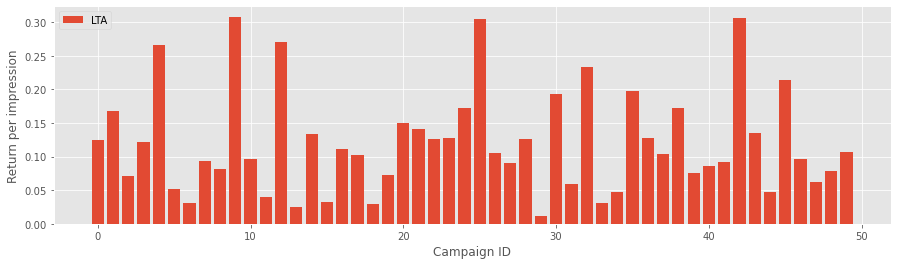

In [33]:
campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## Logistic Regression

In [48]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )


In [49]:
from sklearn.model_selection import train_test_split

x, y = features_for_logistic_regression(df6)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [50]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.861866169404002


In [51]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])


Epoch 1/10
698/698 [==============================] - 5s 7ms/step - loss: 0.5253 - accuracy: 0.7908 - val_loss: 0.4734 - val_accuracy: 0.8059
Epoch 2/10
698/698 [==============================] - 2s 2ms/step - loss: 0.4492 - accuracy: 0.8153 - val_loss: 0.4394 - val_accuracy: 0.8176
Epoch 3/10
698/698 [==============================] - 2s 2ms/step - loss: 0.4234 - accuracy: 0.8265 - val_loss: 0.4223 - val_accuracy: 0.8299
Epoch 4/10
698/698 [==============================] - 1s 2ms/step - loss: 0.4084 - accuracy: 0.8342 - val_loss: 0.4100 - val_accuracy: 0.8346
Epoch 5/10
698/698 [==============================] - 1s 2ms/step - loss: 0.3979 - accuracy: 0.8374 - val_loss: 0.4023 - val_accuracy: 0.8387
Epoch 6/10
698/698 [==============================] - 1s 2ms/step - loss: 0.3905 - accuracy: 0.8417 - val_loss: 0.3954 - val_accuracy: 0.8388: 0s - loss: 0
Epoch 7/10
698/698 [==============================] - 1s 2ms/step - loss: 0.3844 - accuracy: 0.8431 - val_loss: 0.3906 - val_accuracy:

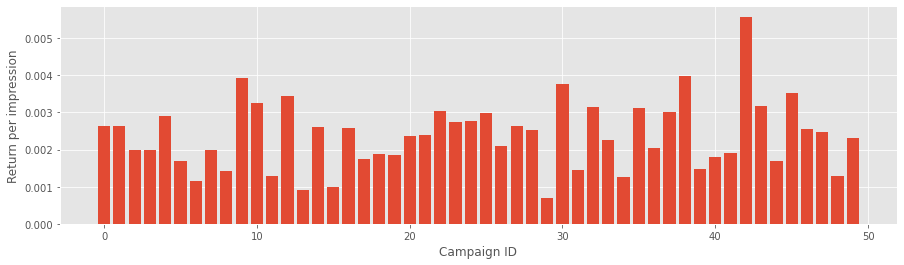

In [52]:
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

## First Touch Attribution

In [74]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
    
    return campaign_conversions / campaign_impressions
#     return campaign_conversions
ft_attr = first_touch_attribution(df6)

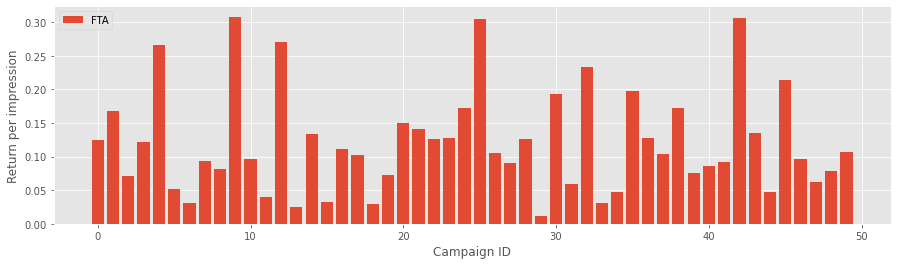

In [75]:
campaign_idx = range(150, 200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), ft_attr[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## Linear Attibution

In [38]:
def linear_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    def weighted_count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for i,row in df.iterrows():
            campaign_id = np.argmax(row.loc["campaigns"])          
            counters[campaign_id] += row.loc['weight']
        return counters
    
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    
    # Assigning equal weights 1/number of clicks
    df_converted['weight']=1/(df_converted['click_nb'])
    #print(df_converted.head())
    campaign_conversions = weighted_count_by_campaign(df_converted)
    return campaign_conversions/campaign_impressions

    
lin_attr = linear_attribution(df6)

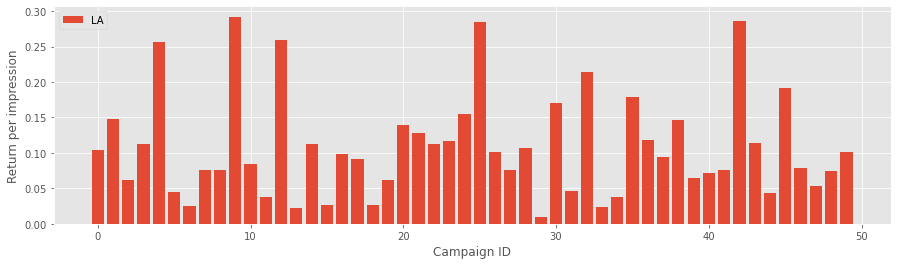

In [76]:
campaign_idx = range(150, 200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lin[campaign_idx])), lin_attr[campaign_idx], label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## U-Shaped Attribution

In [45]:
def u_shaped_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    def weights(click_pos,click_nb):
        if click_nb==2:
            return 0.5
        else:
            if click_pos==0 or click_pos==click_nb-1 :
                return 0.4
            else :
                return 0.2/(click_nb-2)


    def weighted_count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for i,row in df.iterrows():
            campaign_id = np.argmax(row.loc["campaigns"])          
            counters[campaign_id] = counters[campaign_id] + row.loc["weight"]
        return counters
    
    campaign_impressions = count_by_campaign(df)
 
    df_converted = df[df['conversion'] == 1]
    df_converted['weight']=df_converted.apply(lambda x: weights(x.click_pos,x.click_nb), axis=1)
    campaign_conversions = weighted_count_by_campaign(df_converted)
    
    return campaign_conversions / campaign_impressions

u_attr = u_shaped_attribution(df6)

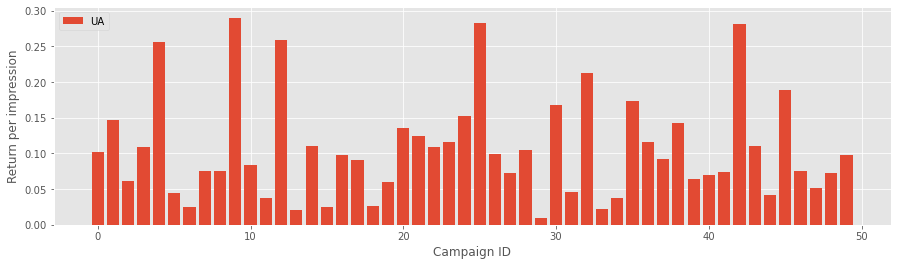

In [77]:
campaign_idx = range(150, 200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(ua[campaign_idx])), u_attr[campaign_idx], label='UA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## Time Decay Attribution

In [82]:
def time_decay(df):
    campaign_count = len(df['campaign'].unique())
    def count_by_campaign(df):
        counters = np.zeros(campaign_count)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id]  = counters[campaign_id] + campaign_one_hot[campaign_id]
        return counters
    campaign_impressions = count_by_campaign(df)
    df_converted = df[df['conversion'] == 1]
    #df_converted['timestamp_max'] = df_converted.groupby(['jid'])['timestamp'].transform(sum)    
    #df_converted["diff"] = df_converted['conversion_timestamp'] - df_converted['timestamp']
    #df_converted['time_decay'] = df_converted["diff"] / df_converted['timestamp_max']
    df_converted['day'] = np.floor(df_converted.conversion_timestamp / 86400.).astype(int)
    df_converted['time_decay'] = df_converted['day'].transform(lambda x: 2**(-x/7))
    df_converted['campaigns'] = df_converted['campaigns'] * df_converted['time_decay']
    campaign_conversions = count_by_campaign(df_converted)
    print(df_converted.sort_values('jid'))
    return campaign_conversions / campaign_impressions
tda = time_decay(df6)

       timestamp       uid  campaign conversion conversion_timestamp  \
157741   1336965   1000023  10341182          1              1425648   
529968   1337893   1000023  10341182          1              1425648   
11816    1152219  10001378  15746419          1              2798558   
521973    290428  10001378  15746419          1              2798558   
396085    910348  10001378  15746419          1              2798558   
...          ...       ...       ...        ...                  ...   
164894   1231727   9999748  15184511          1              2658003   
512138    571143   9999748  15184511          1              2658003   
335942   1617199       999   5061834          1              4103933   
416387   2135364       999   5061834          1              4103933   
118430   2143779       999   5061834          1              4103933   

       conversion_id attribution click click_pos click_nb  ...      cat7  \
157741       5282678           1     1         0        2  

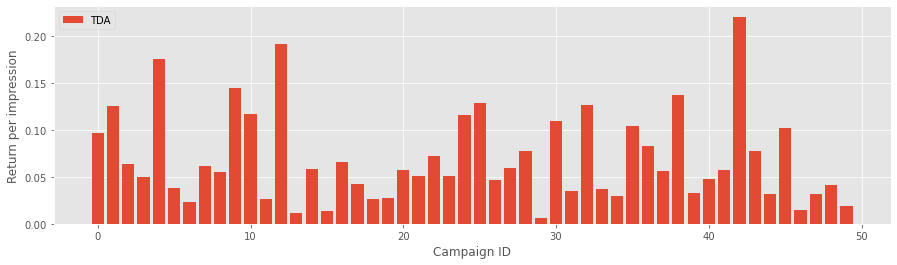

In [101]:
campaign_idx = range(150, 200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(ua[campaign_idx])), tda[campaign_idx], label='TDA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## Comparison of Multi Touch Attribution Models

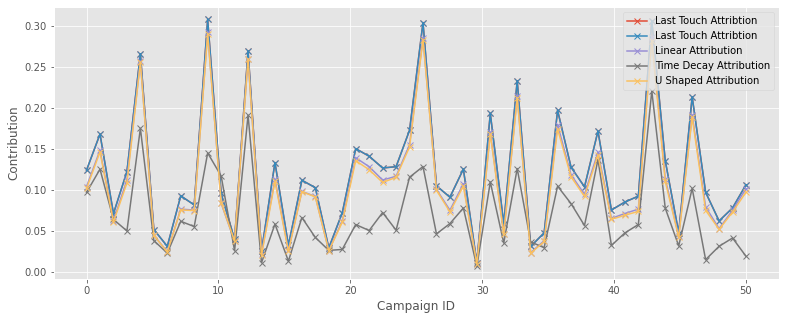

In [84]:
ig = plt.figure(figsize=(13, 5))
campaign_idx=range(150,200)
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)),lta[campaign_idx],marker='x',label='Last Touch Attribtion')
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)),ft_attr[campaign_idx],marker='x',label='Last Touch Attribtion')
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)),lin_attr[campaign_idx],marker='x',label='Linear Attribution')
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)),tda[campaign_idx],marker='x',label='Time Decay Attribution')
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)),u_attr[campaign_idx],marker='x',label='U Shaped Attribution')

plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend()
plt.show()

## Simulation of Return of Investment on the attribution models

In [88]:

# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [95]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
def ROI_model(attr):
    reward=[]
    for i, pitch in enumerate(pitches):
        reward.append(simulate_budget_roi(df6, 10000, attr**pitch))
    return reward

In [99]:
from datetime import datetime

In [100]:
print("now =", datetime.now())
rlog=ROI_model(keras_logreg)
print('rlog done ->',datetime.now())
rushaped=ROI_model(u_attr)
print('rushaped done ->',datetime.now())
rlta=ROI_model(lta)
print('rlta done ->', datetime.now())
rfta=ROI_model(ft_attr)
print('rfta done ->',datetime.now())
rtd=ROI_model(tda)
print('rtd done ->', datetime.now())
rlin=ROI_model(lin_attr)
print('rlin done ->', datetime.now())

now = 2021-03-29 17:07:32.815788
rlog done -> 2021-03-29 17:26:24.933468
rushaped done -> 2021-03-29 17:49:33.022993
rlta done -> 2021-03-29 18:12:16.573091
rfta done -> 2021-03-29 18:36:47.725200
rtd done -> 2021-03-29 18:58:49.500699
rlin done -> 2021-03-29 19:21:31.546179


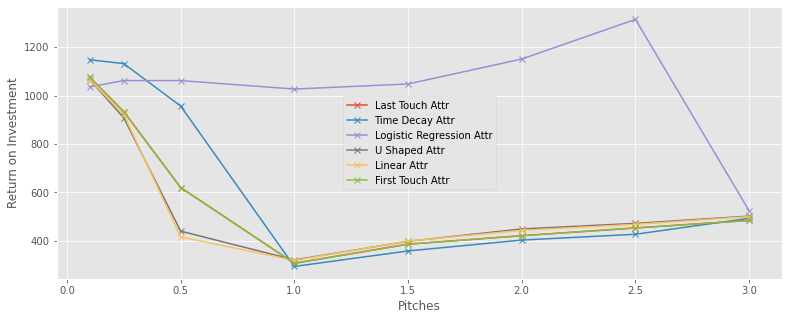

In [103]:
ig = plt.figure(figsize=(13, 5))
plt.plot(pitches,rlta,marker='x',label='Last Touch Attr')
plt.plot(pitches,rtd,marker='x',label='Time Decay Attr')
plt.plot(pitches,rlog,marker='x',label='Logistic Regression Attr')
plt.plot(pitches,rushaped,marker='x',label='U Shaped Attr')
plt.plot(pitches,rlin,marker='x',label='Linear Attr')
plt.plot(pitches,rfta,marker='x',label='First Touch Attr')
plt.xlabel('Pitches')
plt.ylabel('Return on Investment')
plt.legend()
plt.show()

In [110]:
rfta 

[1076, 934, 620, 307, 386, 421, 453, 484]